# Data Modeling Assignment
***

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import graphviz
import random
from scipy.stats import randint

# Data Reading and Extracting
***

In [2]:
# Reading Dataset
ground_water = pd.read_csv("ground_water_quality_2022_post.csv")
ground_water_df = pd.DataFrame(ground_water)
ground_water_df = ground_water_df.dropna()

ground_water_df = ground_water_df.rename(columns = {'NO3 ': 'NO3'})
ground_water_df = ground_water_df.rename(columns = {'RSC  meq  / L': 'RSC'})
numeric = ground_water_df.select_dtypes(include=['number']).columns
nonnumeric = ground_water_df.select_dtypes(exclude=['number']).columns

In [3]:
# Extracting Chosen Feature to Dataframe
chosen = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'mandal', 'village', 'Classification.1']
working_gw_df = ground_water_df[chosen]
working_gw_df = working_gw_df.replace('MR', 'U.S.')

# One-hot encode 'mandal' and 'village' columns separately
mandal_dummies = pd.get_dummies(working_gw_df['mandal'], prefix='mandal')
village_dummies = pd.get_dummies(working_gw_df['village'], prefix='village')

# Concatenate the encoded columns with the original DataFrame
working_gw_df_encoded = pd.concat([working_gw_df.drop(['mandal', 'village'], axis=1), mandal_dummies, village_dummies], axis=1)
working_gw_df_encoded = working_gw_df_encoded.replace('MR', 'U.S.')

# Display the modified DataFrame
working_gw_df_encoded.head()

,RSC,SAR,Na,E.C,TDS,HCO3,pH,Classification.1,mandal_Abdullapurmet,mandal_Achampet,...,village_Yenkiryal,village_Yennaram,village_Yenugonda,village_Yeravaguda,village_Yerkaram,village_Yerrapahad,village_Zafergad,village_Zaptisingaipally,village_kanagala,village_perkit
0,-3.0,1.90,85.0,1065.0,682.0,230.0,8.04,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
1,-0.4,0.79,14.0,122.0,78.0,40.0,8.21,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2.0,3.31,118.0,945.0,605.0,340.0,7.99,U.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
3,-0.2,2.61,104.0,1028.0,658.0,290.0,8.01,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False
4,-1.6,1.87,84.0,1110.0,710.0,300.0,8.11,P.S.,False,False,...,False,False,False,False,False,False,False,False,False,False


# Random Forest Algorithm
***

### Random Forest with All Chosen Features

In [4]:
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

In [5]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [6]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9663608562691132


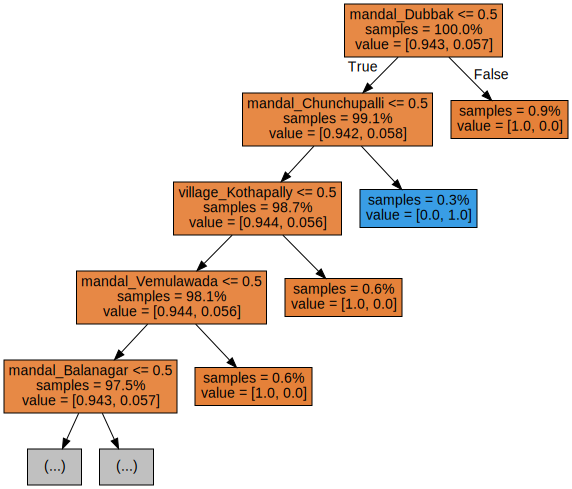

In [7]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Cross Validating Best Hyperparameters all Features

In [8]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BF22795610>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001BF22796410>})

In [9]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 3, 'n_estimators': 61}


In [10]:
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'])
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

In [11]:
# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9021406727828746


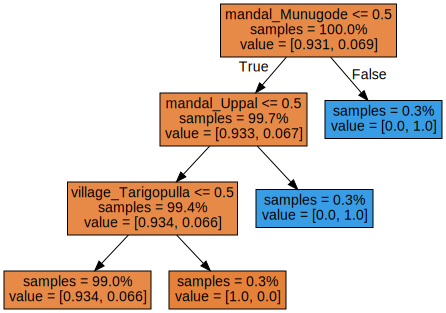

In [12]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Out of Bag Evaluation All Features

Accuracy: 0.9938837920489296


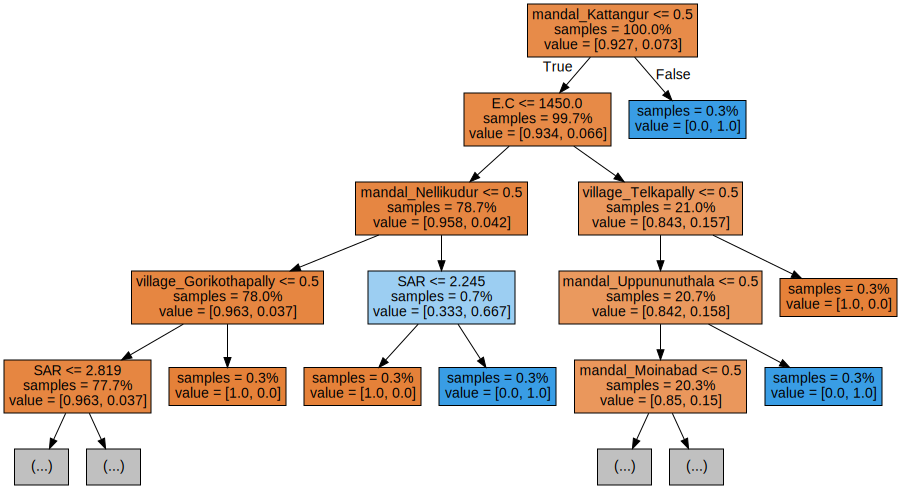

In [13]:
# Splitting Data
X = working_gw_df_encoded.drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Out of Bag Evaluation Cross Validated All Features

Best hyperparameters: {'max_depth': 14, 'n_estimators': 65}
Accuracy: 0.9388379204892966


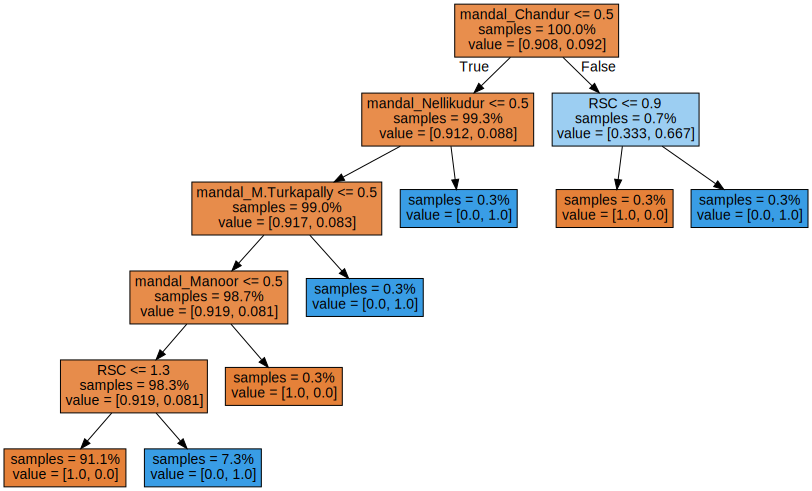

In [14]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], oob_score = True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

### Random Forest with only Numeric Features

Accuracy: 1.0


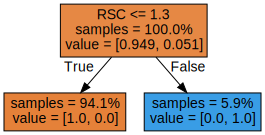

In [15]:
# Splitting Data
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Cross Validating Best Hyperparameters Numeric Features

In [16]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 209}


Accuracy: 0.9969418960244648


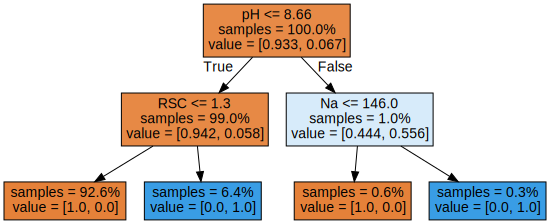

In [17]:
# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'])
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Out of Bag Evaluation Numeric Features

Accuracy: 1.0


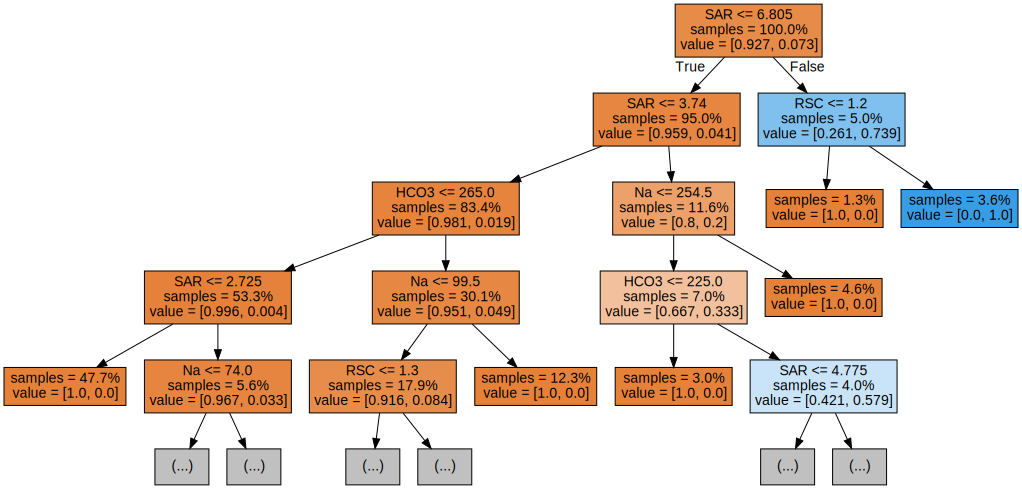

In [18]:
chosen_numeric = ['RSC', 'SAR', 'Na', 'E.C', 'TDS', 'HCO3', 'pH', 'Classification.1']
X = working_gw_df_encoded[chosen_numeric].drop('Classification.1', axis = 1)
y = working_gw_df_encoded['Classification.1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)

# Random Forest
rf = RandomForestClassifier(oob_score = True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = 4, impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)

#### Out of Bag Evaluation Cross Validated Numeric Features

Best hyperparameters: {'max_depth': 4, 'n_estimators': 476}
Accuracy: 1.0


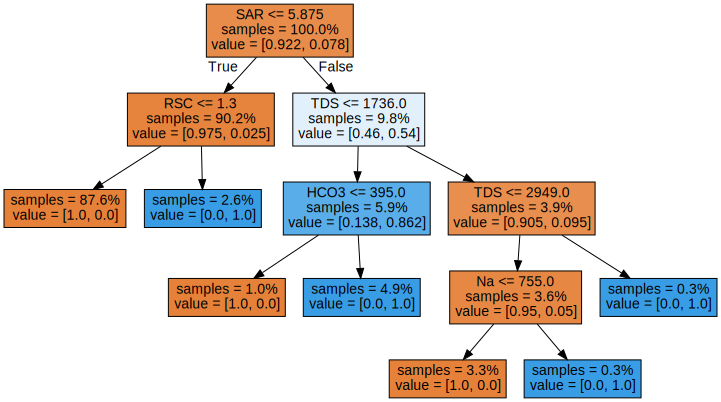

In [19]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

# Random Forest
rf = RandomForestClassifier(n_estimators = rand_search.best_params_['n_estimators'], max_depth = rand_search.best_params_['max_depth'], oob_score = True)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

# Accuracy Test
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree, feature_names = X_train.columns, filled = True, max_depth = rand_search.best_params_['max_depth'], impurity = False, proportion = True)
graph = graphviz.Source(dot_data)
display(graph)